In [1]:
!pip install -q segmentation-models-pytorch
!pip install -q pytorch-lightning==1.9.5
!pip install -q torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 995.6 kB/s eta 0:00:00


In [22]:
import os
import torch
import shutil
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp


from PIL import Image
from pprint import pprint
from torchvision import transforms
from torchvision.transforms import v2 as T
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cuda:0


In [3]:
! git clone https://huggingface.co/datasets/Djulo/Wider_FaceSegLite data/

Streaming output truncated to the last 5000 lines.
	images/44--Aerobics/44_Aerobics_Aerobics_44_317.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_320.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_321.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_329.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_332.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_337.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_339.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_34.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_342.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_343.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_344.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_346.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_35.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_357.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_360.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_364.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_365.jpg
	images/44--Aerobics/44_Aerobics_Aerobics_44_367.j

In [4]:
directory = "data/masks_images"
if not os.path.exists(directory):
    os.makedirs(directory)

In [13]:
! cp -r /content/drive/MyDrive/deep_nn/single_channel/* data/masks_images/

In [6]:
def load_yolo_format(file_path):
  """
  Loads a file in YOLO format and pads coordinates with zeros.

  Args:
    - file_path: path to the file to load.
  Returns:
    - objects: np array of objects in the image. Each object is represented as a
      tuple of (x1, y1, ..., xn, yn), padded with zeros if necessary.
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()

  objects = []
  for line in lines:
    data = line.strip().split()
    class_index = int(data[0]) # We don't care about the class name because we work only with one class (face)
    coordinates = np.array(list(map(float, data[1:])))
    objects.append(coordinates)

  return objects

def segments_to_masks(normalized_segments, image_shape):
    """
    Convert multiple normalized segments to a labeled mask.

    Args:
        normalized_segments (list): List of normalized segments.
        image_shape (tuple): Shape of the original image.

    Returns:
        mask (torch.Tensor): Labeled mask with shape (1, h, w).
    """
    mask = np.zeros(image_shape, dtype=np.int32)

    for i, segment in enumerate(normalized_segments):
        coords = np.array(segment).reshape(-1, 2)

        # Convert normalized coordinates back to original image coordinates
        coords[:, 0] *= image_shape[1]  # width
        coords[:, 1] *= image_shape[0]  # height

        # Ensure coordinates are within the image boundaries
        coords[:, 0] = np.clip(coords[:, 0], 0, image_shape[1] - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, image_shape[0] - 1)

        # Round to integers
        coords = np.round(coords).astype(int)

        # Create a polygon and fill it in the mask
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
        mask[rr, cc] = i + 1

    return mask[np.newaxis, ...]

def found_directory(file_path, folders):
    """
    Finds the directory in which the file is located.

    Args:
        - file_path: path to the file to load.
        - folders: list of folders to look into.

    Returns:
        - folder: name of the folder in which the file is located.
    """
    for i, folder in enumerate(folders):
        file_id = file_path.split('_')[0]
        folder_id = folder.split('--')[0]
        if file_id == folder_id:
            return folders[i]
    raise ValueError(f"Folder {folders} not found in {file_path}")

In [14]:
root_dir = "data"
mask_folder = os.path.join(root_dir, 'masks')
mask_files = sorted(os.listdir(mask_folder))

image_folder = os.path.join(root_dir, 'images')
image_files = [os.path.join(image_folder, found_directory(file_path, os.listdir(image_folder)),
        file_path.replace('txt', 'jpg')) for file_path in mask_files]

In [8]:
target_dir = 'data/selected_images'

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Copy each image in the dataset
for image_path in image_files:
    # Extract the filename from the path
    filename = os.path.basename(image_path)

    # Define the destination path
    dest_path = os.path.join(target_dir, filename)

    # Copy the file
    shutil.copy2(image_path, dest_path)

In [9]:
class FslDataset(Dataset):
    def __init__(self, root_dir, transforms=None, subset_files=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Get the mask files
        self.mask_folder = os.path.join(root_dir, 'masks_images')
        self.mask_files = sorted(os.listdir(self.mask_folder))

        # Get the image files
        self.image_folder = os.path.join(root_dir, 'selected_images')
        self.image_files = sorted(os.listdir(self.image_folder))

        # If a subset of files is provided, use that subset
        if subset_files is not None:
            self.mask_files = [self.mask_files[i] for i in subset_files]
            self.image_files = [self.image_files[i] for i in subset_files]

    def __len__(self):
        return len(self.mask_files)

    def __getitem__(self, idx):
        # Get the image
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        image = np.array(Image.open(image_path))
        image = transforms.ToTensor()(image)

        # Get the mask
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
        mask = np.array(Image.open(mask_path))
        mask = transforms.ToTensor()(mask)

        sample = {'image': image, 'mask': mask}

        # Apply transforms if any
        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

In [10]:
def split_dataset(dataset, transforms=None, train_size=0.75, valid_size=0.10, test_size=0.15):
    assert train_size + valid_size + test_size == 1, "The proportions must sum up to 1"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(train_size * dataset_size)
    valid_split = int(valid_size * dataset_size)

    # Randomly shuffle the indices
    np.random.shuffle(indices)

    train_indices = indices[:train_split]
    valid_indices = indices[train_split:train_split + valid_split]
    test_indices = indices[train_split + valid_split:]

    # Create subset datasets
    train_dataset = FslDataset(dataset.root_dir, transforms, subset_files=train_indices)
    valid_dataset = FslDataset(dataset.root_dir, transforms, subset_files=valid_indices)
    test_dataset = FslDataset(dataset.root_dir, transforms, subset_files=test_indices)

    return train_dataset, valid_dataset, test_dataset

In [11]:
def custom_collate_fn(batch):
    # Target size for resizing
    target_size = (256, 256)

    batch_images = []
    batch_masks = []

    for item in batch:
        image, mask = item['image'], item['mask']

        # Resize image and mask. Use different modes for images and masks
        resize_image = transforms.Resize(target_size)
        resize_mask = transforms.Resize(target_size)

        # Convert to PIL Image for resizing if necessary
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if isinstance(mask, torch.Tensor):
            mask = transforms.ToPILImage()(mask)

        # Apply transformations
        image = resize_image(image)
        mask = resize_mask(mask)

        # Convert back to tensor
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        batch_images.append(image)
        batch_masks.append(mask)

    # Stack all images and masks
    images = torch.stack(batch_images)
    masks = torch.stack(batch_masks)

    return {'image': images, 'mask': masks}

In [15]:
fsl_dataset = FslDataset(root_dir='data')
trans = transforms.Compose([T.Resize((256, 256)), T.ToDtype(torch.float, scale=True), T.ToPureTensor()])
train_dataset, valid_dataset, test_dataset = split_dataset(fsl_dataset)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu, collate_fn=custom_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu, collate_fn=custom_collate_fn)

Train size: 1251
Valid size: 166
Test size: 251


In [16]:
# Check if batch size is correct
for idx, batch in enumerate(test_dataloader):
  if idx == 1:
    break
  print(batch['mask'].size())

torch.Size([16, 1, 256, 256])


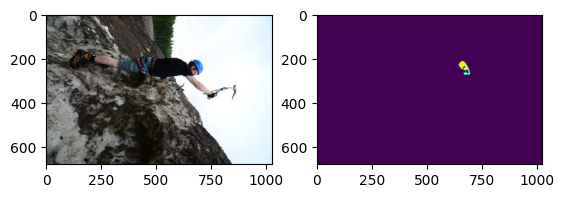

In [17]:
# lets look at some sample
sample = train_dataset[5]
plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].permute(1, 2, 0))  # same for the mask
plt.show()

In [18]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.block1 = conv_block(3, 16)
        self.block2 = conv_block(16, 32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64, 128)
        self.block5 = conv_block(128, 256)

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.block6 = conv_block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.block7 = conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.block8 = conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.block9 = conv_block(32, 16)

        self.output = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        pool1 = F.max_pool2d(block1, 2)
        block2 = self.block2(pool1)
        pool2 = F.max_pool2d(block2, 2)
        block3 = self.block3(pool2)
        pool3 = F.max_pool2d(block3, 2)
        block4 = self.block4(pool3)
        pool4 = F.max_pool2d(block4, 2)
        block5 = self.block5(pool4)

        up6 = self.upconv4(block5)
        concat6 = torch.cat([up6, block4], dim=1)
        block6 = self.block6(concat6)
        up7 = self.upconv3(block6)
        concat7 = torch.cat([up7, block3], dim=1)
        block7 = self.block7(concat7)
        up8 = self.upconv2(block7)
        concat8 = torch.cat([up8, block2], dim=1)
        block8 = self.block8(concat8)
        up9 = self.upconv1(block8)
        concat9 = torch.cat([up9, block1], dim=1)
        block9 = self.block9(concat9)

        out = self.output(block9)

        return out

In [20]:
class FaceModel(pl.LightningModule):

    def __init__(self, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = UNet(num_classes=out_classes)

        # preprocessing parameteres for image
        self.register_buffer("std", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]


        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [21]:
model = FaceModel(in_channels=3, out_classes=1)

In [23]:
max_epochs = 10

# Train the model
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=max_epochs,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 1.9 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.770     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_dataset_iou': 0.19680888950824738,
  'valid_per_image_iou': 0.16473133862018585}]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.1879054754972458,
  'test_per_image_iou': 0.15071412920951843}]


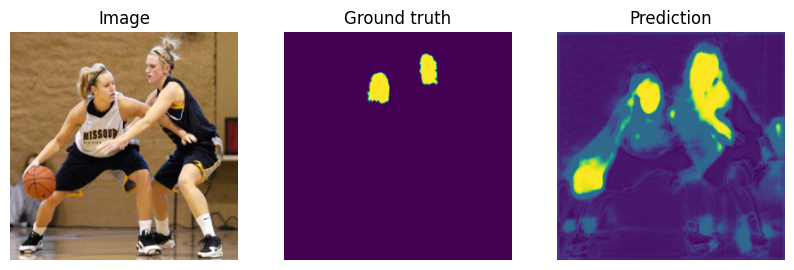

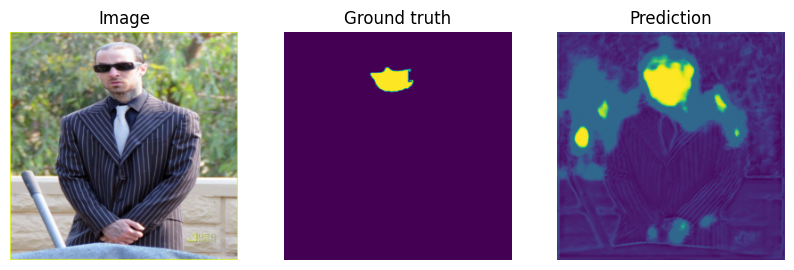

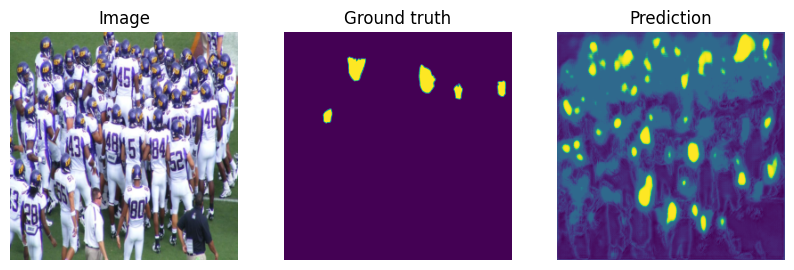

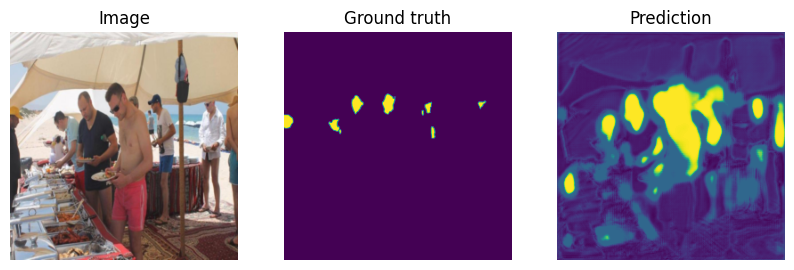

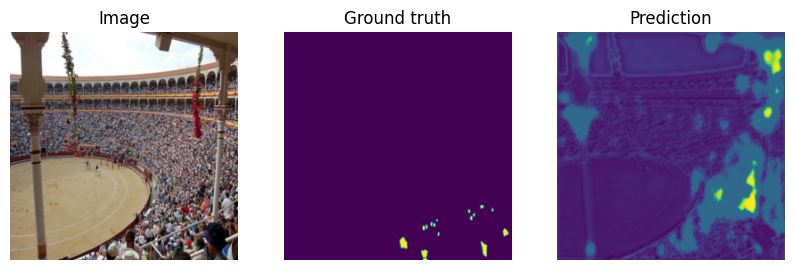

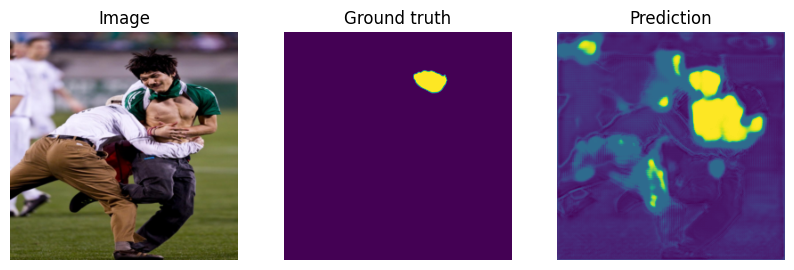

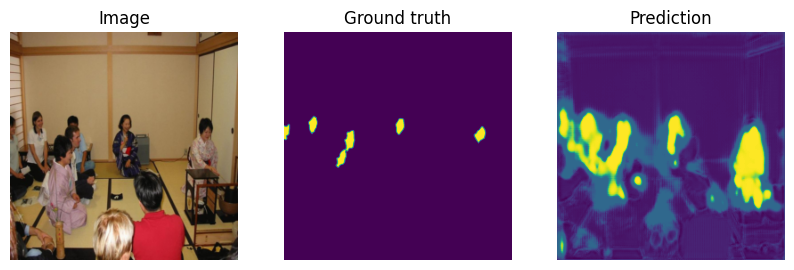

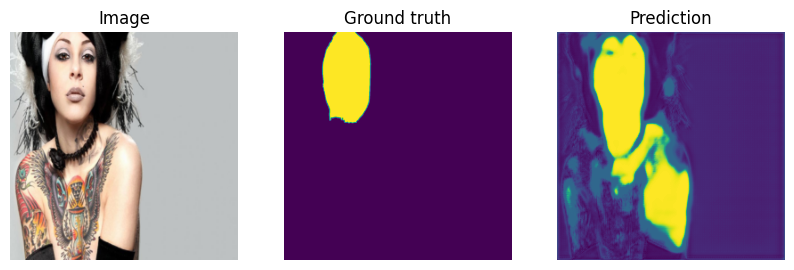

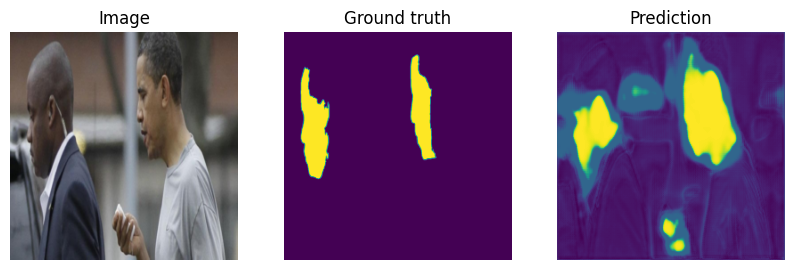

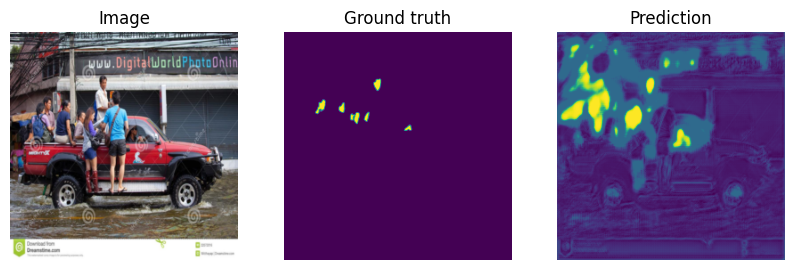

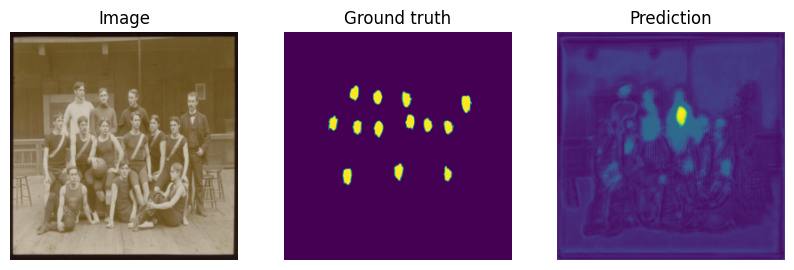

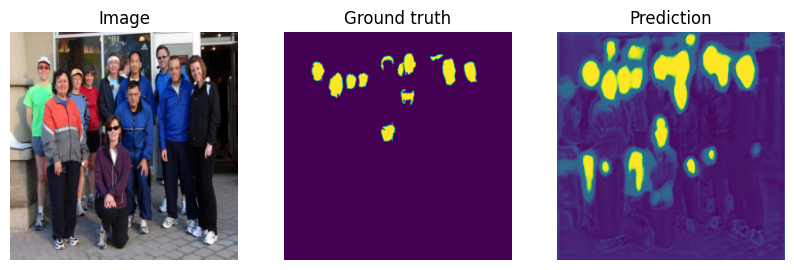

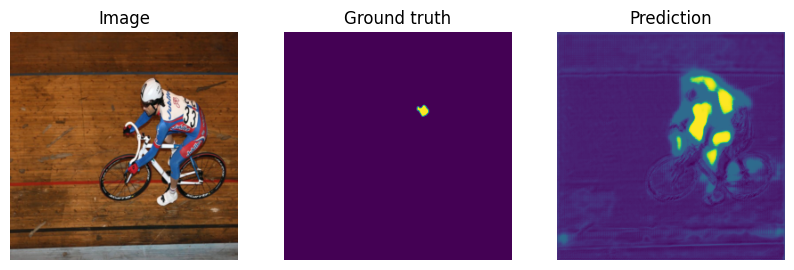

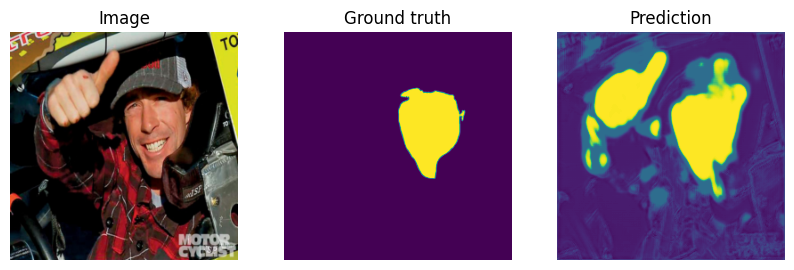

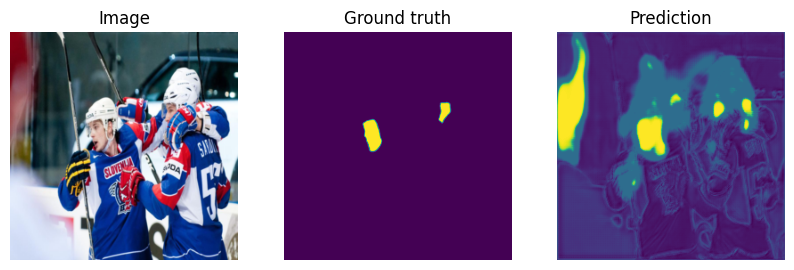

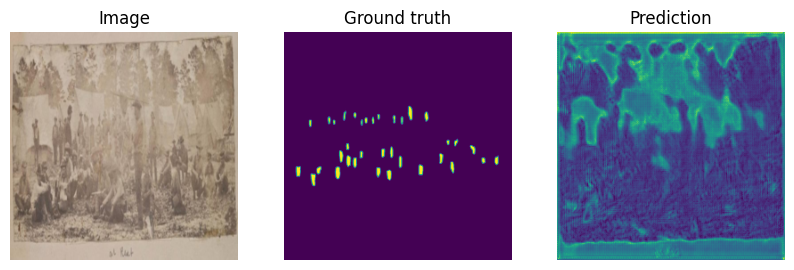

In [24]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
pr_masks = pr_masks.numpy().squeeze()
pr_masks = pr_masks > 0.5

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [25]:
torch.save(model.state_dict(), 'unet_model_small_v1.pth')
print("Model saved.")

Model saved.


In [27]:
! cp -r /content/unet_model_small_v1.pth /content/drive/MyDrive/deep_nn/